<a href="https://colab.research.google.com/github/hereisamara/BodyPix-Evaluation/blob/main/BodyPix_evaluation_on_OCHuman.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Git clone OCHumanApi and install

In [2]:
!git clone https://github.com/liruilong940607/OCHumanApi --quiet
%cd OCHumanApi
!pip install .  --quiet

/content/OCHumanApi
Processing /content/OCHumanApi
  Preparing metadata (setup.py) ... done
  Created wheel for ochumanApi: filename=ochumanApi-0.0-cp310-cp310-linux_x86_64.whl size=369020 sha256=b091e2b4692946940ed76bb40accd3a75667c64ca5b4f8e3b8c84f0e31b747f5
  Stored in directory: /tmp/pip-ephem-wheel-cache-399q5iil/wheels/10/24/56/2a37d7b3e55767b0a4e89022ec4083dbdea33aa3b5b4ecf4b7
Successfully built ochumanApi


# Download OCHumanData and Unzip

first download the data from OCHumanAPI and save to a folder

In [4]:
!unzip /content/drive/MyDrive/OCHuman.zip -d /content/drive/MyDrive/OCHumanData

Archive:  /content/drive/MyDrive/OCHuman-20240424T083605Z-001.zip
replace /content/drive/MyDrive/OCHumanData/OCHuman/ochuman_coco_format_test_range_0.00_1.00.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!unzip /content/drive/MyDrive/OCHumanData/OCHuman/images.zip -d /content/drive/MyDrive/OCHumanData/OCHuman/images/

# Install BodyPix python

In [1]:
!pip install tf-bodypix --quiet
!pip install tfjs-graph-converter --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 61.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 76.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 58.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 82.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 55.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 21.3 MB/s eta 0:00:00


# Import Library

In [7]:
import glob
import numpy as np
import cv2, os
from pathlib import Path
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 8)

# Visulalize OCHuman Data

In [9]:
## Initialize
from ochumanApi.ochuman import OCHuman
## Load annotations & Visualize
import ochumanApi.vis as vistool
from ochumanApi.ochuman import Poly2Mask

base_path = "/content/drive/MyDrive/OCHumanData/OCHuman/"

ochuman = OCHuman(AnnoFile=os.path.join(base_path,'ochuman.json'), Filter='kpt&segm')
image_ids = ochuman.getImgIds()
print ('Total images: %d'%len(image_ids))

ImgDir = os.path.join(base_path,'images/images/')
data = ochuman.loadImgs(imgIds=[image_ids[2]])[0]

img = cv2.imread(os.path.join(ImgDir, data['file_name']))
height, width = data['height'], data['width']

Total images: 4731


# True Mask

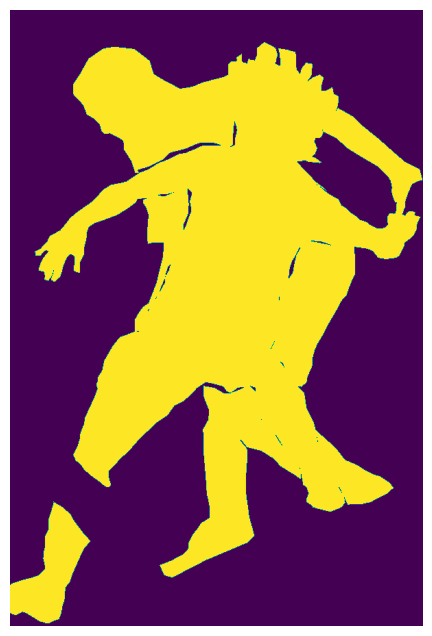

In [22]:
colors = [[255, 0, 0],
         [255, 255, 0],
         [0, 255, 0],
         [0, 255, 255],
         [0, 0, 255],
         [255, 0, 255]]

final_mask = np.zeros((height, width), dtype=np.uint8)  # Initialize a mask with zeros

# Process each annotation in the image
for anno in data['annotations']:
    segm = anno.get('segms')
    if segm:
        mask = Poly2Mask(segm)  # Convert segmentation polygon to mask
        final_mask = np.bitwise_or(final_mask, mask)  # Combine the mask with the final mask

plt.imshow(final_mask)
# plt.imshow(img[:,:,::-1])
plt.axis('off')
plt.show()

# BodyPIX

### load model

In [11]:
import tensorflow as tf
from tf_bodypix.api import download_model, load_model, BodyPixModelPaths

# load model (once)
bodypix_model = load_model(download_model(
    # BodyPixModelPaths.MOBILENET_FLOAT_50_STRIDE_16
    BodyPixModelPaths.RESNET50_FLOAT_STRIDE_16
))

### predict

In [23]:
result = bodypix_model.predict_single(img)
binary_mask = result.get_mask(threshold=0.75)
# colored_mask = result.get_colored_part_mask(binary_mask)

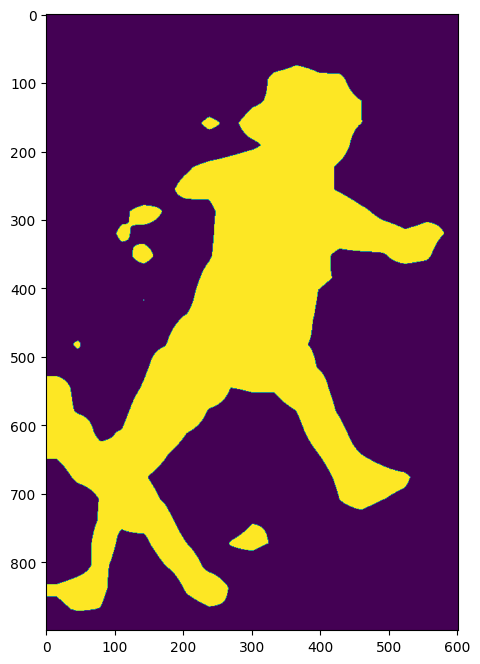

In [24]:
plt.imshow(binary_mask)

# Evaluating on one image

In [25]:
import numpy as np

def calculate_metrics(true_mask, pred_mask):
    # Ensure both masks have the same 2D shape
    true_mask = np.squeeze(true_mask)
    pred_mask = np.squeeze(pred_mask)
    # True positives, false positives, true negatives, false negatives
    TP = np.sum((pred_mask == 1) & (true_mask == 1))
    FP = np.sum((pred_mask == 1) & (true_mask == 0))
    TN = np.sum((pred_mask == 0) & (true_mask == 0))
    FN = np.sum((pred_mask == 0) & (true_mask == 1))

    # Calculate metrics
    iou = TP / (TP + FP + FN)
    dice = (2 * TP) / (2*TP + FP + FN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    accuracy = (TP + TN) / (TP + FP + TN + FN)

    return iou, dice, precision, recall, accuracy

# Example usage
true_mask = masks[0]

pred_mask = binary_mask

metrics = calculate_metrics(true_mask, pred_mask)
print("IoU:", metrics[0])
print("Dice:", metrics[1])
print("Precision:", metrics[2])
print("Recall:", metrics[3])
print("Accuracy:", metrics[4])


IoU: 0.6857474888103923
Dice: 0.8135826906013242
Precision: 0.7753421449758027
Recall: 0.8557910456333822
Accuracy: 0.8991805094130676


# For a whole dataset

In [ ]:
import numpy as np
from tqdm import tqdm
from ochumanApi.ochuman import OCHuman, Poly2Mask
import glob
import numpy as np
import cv2, os
from pathlib import Path
import tensorflow as tf
from tf_bodypix.api import download_model, load_model, BodyPixModelPaths

# load model (once)
bodypix_model = load_model(download_model(
    # BodyPixModelPaths.MOBILENET_FLOAT_50_STRIDE_16
    BodyPixModelPaths.RESNET50_FLOAT_STRIDE_16
))

def calculate_metrics(true_mask, pred_mask):
    # Ensure both masks have the same 2D shape
    true_mask = np.squeeze(true_mask)
    pred_mask = np.squeeze(pred_mask)

    TP = np.sum((pred_mask == 1) & (true_mask == 1))
    FP = np.sum((pred_mask == 1) & (true_mask == 0))
    TN = np.sum((pred_mask == 0) & (true_mask == 0))
    FN = np.sum((pred_mask == 0) & (true_mask == 1))

    iou = TP / (TP + FP + FN) if (TP + FP + FN) > 0 else 0
    dice = (2 * TP) / (2 * TP + FP + FN) if (2 * TP + FP + FN) > 0 else 0
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    accuracy = (TP + TN) / (TP + FP + TN + FN) if (TP + FP + TN + FN) > 0 else 0

    return iou, dice, precision, recall, accuracy

def evaluate_dataset(anno_file, img_dir, bodypix_model):
    # Initialize lists to hold metric values
    ious, dices, precisions, recalls, accuracies = [], [], [], [], []

    # Initialize OCHuman API
    ochuman = OCHuman(AnnoFile=anno_file, Filter='kpt&segm')
    # Get all image IDs
    image_ids = ochuman.getImgIds()

    # Loop over each image ID
    for img_id in tqdm(image_ids, desc="Evaluating the images"):
        data = ochuman.loadImgs(imgIds=[img_id])[0]  # Load image data
        img_path = os.path.join(img_dir, data['file_name'])  # Path to the image
        img = cv2.imread(img_path)  # Read the image
        height, width = data['height'], data['width']

        true_mask = np.zeros((height, width), dtype=np.uint8)  # Initialize a mask with zeros

        # Process each annotation in the image
        for anno in data['annotations']:
            segm = anno.get('segms')
            if segm:
                mask = Poly2Mask(segm)  # Convert segmentation polygon to mask
                true_mask = np.bitwise_or(true_mask, mask)
        ##OR {
        # true_mask = Poly2Mask(data['annotations'][0].get('segms')) # get only the first mask
        ##}

        #predict the mask
        result = bodypix_model.predict_single(img)
        pred_mask = result.get_mask(threshold=0.75)

        metrics = calculate_metrics(true_mask, pred_mask)
        ious.append(metrics[0])
        dices.append(metrics[1])
        precisions.append(metrics[2])
        recalls.append(metrics[3])
        accuracies.append(metrics[4])

    # Calculate mean metrics
    mean_iou = np.mean(ious)
    mean_dice = np.mean(dices)
    mean_precision = np.mean(precisions)
    mean_recall = np.mean(recalls)
    mean_accuracy = np.mean(accuracies)

    return mean_iou, mean_dice, mean_precision, mean_recall, mean_accuracy


# Evaluate the dataset
anno_file = '/content/drive/MyDrive/OCHumanData/OCHuman/ochuman.json'
img_dir = '/content/drive/MyDrive/OCHumanData/OCHuman/images/images/'
results = evaluate_dataset(anno_file, img_dir, bodypix_model)

print("Mean IoU:", results[0])
print("Mean Dice:", results[1])
print("Mean Precision:", results[2])
print("Mean Recall:", results[3])
print("Mean Accuracy:", results[4])

# Batch processing for CPU

In [30]:
import numpy as np
import cv2
from tqdm import tqdm
from ochumanApi.ochuman import OCHuman, Poly2Mask

def calculate_metrics(true_mask, pred_mask):
    # Ensure both masks have the same 2D shape
    true_mask = np.squeeze(true_mask)
    pred_mask = np.squeeze(pred_mask)

    TP = np.sum((pred_mask == 1) & (true_mask == 1))
    FP = np.sum((pred_mask == 1) & (true_mask == 0))
    TN = np.sum((pred_mask == 0) & (true_mask == 0))
    FN = np.sum((pred_mask == 0) & (true_mask == 1))

    iou = TP / (TP + FP + FN) if (TP + FP + FN) > 0 else 0
    dice = (2 * TP) / (2 * TP + FP + FN) if (2 * TP + FP + FN) > 0 else 0
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    accuracy = (TP + TN) / (TP + FP + TN + FN) if (TP + FP + TN + FN) > 0 else 0

    return iou, dice, precision, recall, accuracy

def evaluate_dataset_in_batches(anno_file, img_dir, bodypix_model, batch_size=100):
    # Initialize OCHuman API
    ochuman = OCHuman(AnnoFile=anno_file, Filter='kpt&segm')
    # Get all image IDs
    image_ids = ochuman.getImgIds()
    total_batches = (len(image_ids) + batch_size - 1) // batch_size  # Calculate the total number of batches

    # Process each batch
    for batch_index in range(total_batches):
        start_index = batch_index * batch_size
        end_index = min((batch_index + 1) * batch_size, len(image_ids))
        current_image_ids = image_ids[start_index:end_index]

        # Metrics for current batch
        ious, dices, precisions, recalls, accuracies = [], [], [], [], []

        for img_id in tqdm(current_image_ids, desc=f"Batch {batch_index + 1}/{total_batches}"):
            data = ochuman.loadImgs(imgIds=[img_id])[0]
            img_path = os.path.join(img_dir, data['file_name'])
            img = cv2.imread(img_path)

            if img is None:
                print("Failed to load image at:", img_path)
                continue

            true_mask = Poly2Mask(data['annotations'][0].get('segms'))  # Only the first mask

            result = bodypix_model.predict_single(img)
            pred_mask = result.get_mask(threshold=0.75)

            metrics = calculate_metrics(true_mask, pred_mask)
            ious.append(metrics[0])
            dices.append(metrics[1])
            precisions.append(metrics[2])
            recalls.append(metrics[3])
            accuracies.append(metrics[4])

        # Calculate mean metrics for the batch
        mean_iou = np.mean(ious)
        mean_dice = np.mean(dices)
        mean_precision = np.mean(precisions)
        mean_recall = np.mean(recalls)
        mean_accuracy = np.mean(accuracies)

        print(f"Results for Batch {batch_index + 1}:")
        print(f"  Mean IoU: {mean_iou}")
        print(f"  Mean Dice: {mean_dice}")
        print(f"  Mean Precision: {mean_precision}")
        print(f"  Mean Recall: {mean_recall}")
        print(f"  Mean Accuracy: {mean_accuracy}")

# Evaluate the dataset in batches
anno_file = '/content/drive/MyDrive/OCHumanData/OCHuman/ochuman.json'
img_dir = '/content/drive/MyDrive/OCHumanData/OCHuman/images/images/'
evaluate_dataset_in_batches(anno_file, img_dir, bodypix_model, batch_size=100)

Batch 1/48: 100%|██████████| 100/100 [01:15<00:00,  1.32it/s]

Results for Batch 1:
  Mean IoU: 0.4208946218492464
  Mean Dice: 0.5739033855574697
  Mean Precision: 0.47032030400136987
  Mean Recall: 0.8012477061013574
  Mean Accuracy: 0.8199856131389232
